# Fashion MNIST Classifier

### Import everything and define train and test sets/loaders

In [ ]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets


assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Declare the transform
transform = transforms.Compose(
    [transforms.ToTensor(), # Transform image to tensor
     transforms.Normalize((0.5,),(0.5,))] # Normalize data
)

# Declare training and testing sets
train_set = datasets.FashionMNIST('data',
  download=True,
  train=True,
  transform=transform
)
test_set = datasets.FashionMNIST('data',
  download=True,
  train=False,
  transform=transform
)

# Declare dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                           shuffle=True, num_workers=1)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


# Here we can see the images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = train_set.data[i,...]
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off');

  

### Define our classifier

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256) # Input layer should be 784 because images are 28x28 - one for every feature (pixel)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10) # we have 10 classes so output should be one of those

    def forward(self, x):
        # make sure input is flat
        x = x.view(x.shape[0], -1)

        # for every layer we should activate output with ReLU
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
        

### Define loss function and optimizer 

This `initialize_parameters()` function allows us to change the initial weights and biases. Although I find changing the initial parameters to the inccorect thing sort of breaks the neural network.

It is important that initial weights and biases are set correctly otherwise the neural network may die or get stuck on plateaus.

You can find more initialization methods in the [`torch.nn.init`](https://pytorch.org/docs/stable/nn.init.html?highlight=init) module.

In [11]:
def initialize_parameters(model):
    for name, w in model.named_parameters():
        print(name, w)
        if "weight" in name:
            nn.init.eye_(w)
        
        if "bias" in name:
            nn.init.zeros_(w)   

In [20]:
import torch.optim as optim

# Create model instance
model = Classifier()
model.cuda()# Move to GPU

# Define metric for loss function
criterion = nn.NLLLoss()

# Select optimizer and pass learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Here we change the initial weights+bias in each layer
# initialize_parameters(model)

### Test gradient computation

In [ ]:
images, labels = next(iter(train_loader))
log_ps = model(images.cuda())
loss = criterion(log_ps, labels.cuda())

loss.backward()

print(model.fc2.weight.grad)

### Training Loop


In [21]:
losses = {'train': [], 'eval': []} # this will be used to graph loss

epochs = 10
for e in range(epochs):
    # Training
    total_loss = 0
    
    model.train() # Turn on training mode

    for images, labels in train_loader:
        optimizer.zero_grad() # Zero gradients to start off loop

        # Forward pass
        output = model(images.cuda())
        loss = criterion(output, labels.cuda())

        # Backward pass // calc derivatvies 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    else:
        print(f'Training loss: {total_loss / len(train_loader)}', end=' ')
        losses['train'].append(total_loss / len(train_loader))

    # Evaluation
    model.eval()
    with torch.no_grad():
        total = 0
        total_loss = 0 # we get the total loss here to graph it later
        correct = 0
        for images, labels in test_loader:
            output = model(images.cuda())
            loss = criterion(output, labels.cuda())

            total_loss += loss.item()

            mx_index = torch.argmax(output, dim=1)
            total += labels.numel()
            correct += sum(mx_index == labels.cuda()).item()

        print(f'Test Accuracy {correct / total * 100:.2f}')
        losses['eval'].append(total_loss/len(test_loader))



Training loss: 1.2976862819972577 Test Accuracy 73.39
Training loss: 0.6119189207741955 Test Accuracy 79.02
Training loss: 0.5231141786712573 Test Accuracy 80.48
Training loss: 0.47556767267967337 Test Accuracy 81.43
Training loss: 0.44516373320873864 Test Accuracy 82.72
Training loss: 0.42562204559665245 Test Accuracy 83.35
Training loss: 0.40807751864830316 Test Accuracy 84.07
Training loss: 0.3917325128084307 Test Accuracy 85.09
Training loss: 0.37932195071218366 Test Accuracy 84.69
Training loss: 0.36699360110231044 Test Accuracy 85.06


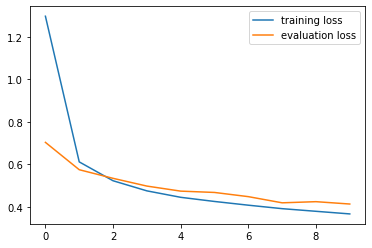

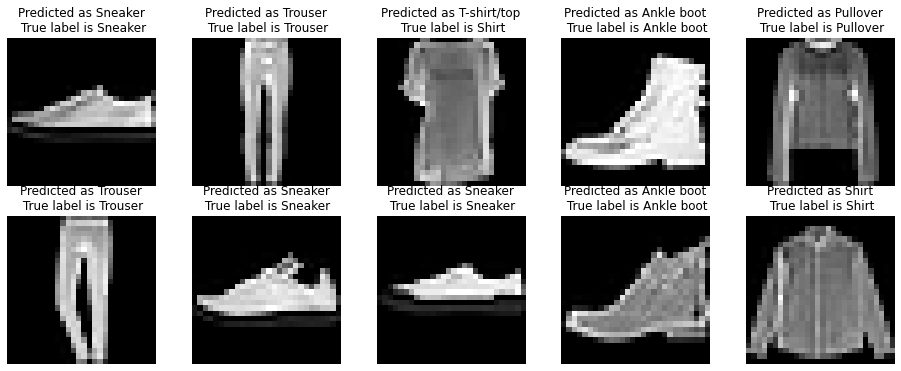

In [23]:
plt.plot(losses["train"], label="training loss")
plt.plot(losses["eval"], label="evaluation loss")

plt.legend()
plt.pause(0.000001)
plt.show()

print()

with torch.no_grad():
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)

    data = data.view(-1, 28*28)
    output = model(data)
    predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
    true = target.cpu().numpy().tolist()
      
    plt.figure(figsize=(16, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        image = data[i,...].cpu().numpy().reshape((28,28))
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.title('Predicted as {}\n True label is {}'.format(test_set.classes[predictions[i]], test_set.classes[true[i]], ))